# 🎵 Correlazione tra Caratteristiche Audio ed Emozioni 🎵

Questo notebook si concentra sulla correlazione tra le caratteristiche audio estratte con Librosa e le annotazioni emotive (arousal e valence) del dataset DEAM.

## 1. Preparazione dell'ambiente

Importiamo le librerie necessarie per la nostra analisi.

In [11]:
import librosa  # Libreria principale per l'analisi audio
import librosa.display  # Per visualizzare i grafici audio
import matplotlib.pyplot as plt  # Per creare grafici
import numpy as np  # Per calcoli matematici
import pandas as pd  # Per gestire i dati in formato tabellare
import seaborn as sns  # Per grafici statistici avanzati
from scipy import stats  # Per analisi statistiche

# Impostiamo alcune opzioni di visualizzazione
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne
sns.set_theme(style='whitegrid')  # Stile dei grafici seaborn

## 2. Caricamento dei dati di esempio

Per questo notebook, creiamo dati di esempio che simulano le caratteristiche audio estratte e le annotazioni emotive.

In [4]:
# Creiamo dati di esempio per le caratteristiche audio
# Simuliamo 45 secondi di un brano
np.random.seed(42)  # Per riproducibilità

# Creiamo un DataFrame con le caratteristiche audio per ogni secondo
seconds = range(1, 46)  # 45 secondi

# Caratteristiche correlate all'arousal (eccitazione/energia)
# RMS (energia) - cresce gradualmente
rms = np.linspace(0.05, 0.25, 45) + np.random.normal(0, 0.02, 45)

# Centroide spettrale - varia in modo sinusoidale
centroid = 2000 + 500 * np.sin(np.linspace(0, 4*np.pi, 45)) + np.random.normal(0, 100, 45)

# Zero crossing rate - correlato alla ruvidità/rumorosità
zcr = 0.1 + 0.05 * np.sin(np.linspace(0, 6*np.pi, 45)) + np.random.normal(0, 0.01, 45)

# Caratteristiche correlate alla valence (positività/negatività)
# Contrasto spettrale - inizia basso e cresce
contrast = np.linspace(1.0, 5.0, 45) + np.random.normal(0, 0.5, 45)

# Chroma media - varia in modo casuale ma con trend
chroma_mean = 0.3 + 0.1 * np.cumsum(np.random.normal(0, 0.05, 45))
chroma_mean = (chroma_mean - min(chroma_mean)) / (max(chroma_mean) - min(chroma_mean)) * 0.5 + 0.2

# MFCC primo coefficiente - correlato all'energia
mfcc1 = -30 + 10 * np.linspace(0, 1, 45) + np.random.normal(0, 2, 45)

# Creiamo il DataFrame delle caratteristiche
features_df = pd.DataFrame({
    'second': seconds,
    'rms': rms,
    'spectral_centroid': centroid,
    'zero_crossing_rate': zcr,
    'spectral_contrast': contrast,
    'chroma_mean': chroma_mean,
    'mfcc_1': mfcc1
})

# Creiamo dati di esempio per le annotazioni emotive
# Arousal (eccitazione/energia) - correlata principalmente con RMS e centroide spettrale
arousal = 2.0 + 5.0 * (rms / max(rms)) + 1.0 * (centroid / max(centroid)) + np.random.normal(0, 0.3, 45)
arousal = np.clip(arousal, 1.0, 9.0)  # Limitiamo i valori tra 1 e 9

# Valence (positività/negatività) - correlata principalmente con contrasto spettrale e chroma
valence = 3.0 + 3.0 * (contrast / max(contrast)) + 2.0 * chroma_mean + np.random.normal(0, 0.3, 45)
valence = np.clip(valence, 1.0, 9.0)  # Limitiamo i valori tra 1 e 9

# Aggiungiamo le annotazioni emotive al DataFrame
features_df['arousal'] = arousal
features_df['valence'] = valence

# Mostriamo le prime righe del DataFrame
print("Caratteristiche audio e annotazioni emotive per ogni secondo:")
print(features_df.head())

# Statistiche descrittive
print("Statistiche descrittive:")
print(features_df.describe().round(2))

Caratteristiche audio e annotazioni emotive per ogni secondo:
   second       rms  spectral_centroid  zero_crossing_rate  spectral_contrast  \
0       1  0.059934        1928.015579            0.100971           1.774967   
1       2  0.051780        2094.802401            0.130457           0.699282   
2       3  0.072045        2376.032631            0.130767           1.020787   
3       4  0.094097        2412.236616            0.144698           1.679486   
4       5  0.063499        2278.511982            0.145570           0.748204   

   chroma_mean     mfcc_1   arousal   valence  
0     0.422096 -27.822099  4.374832  4.687730  
1     0.382389 -29.644167  3.409258  4.299210  
2     0.332781 -31.700944  4.705934  4.053980  
3     0.355131 -30.748789  4.820859  4.599712  
4     0.344780 -27.731714  3.852467  4.003438  
Statistiche descrittive:
       second    rms  spectral_centroid  zero_crossing_rate  \
count   45.00  45.00              45.00               45.00   
mean    23.0

## 3. Visualizzazione dell'evoluzione delle emozioni nel tempo

Visualizziamo come cambiano arousal e valence durante l'evoluzione del brano.

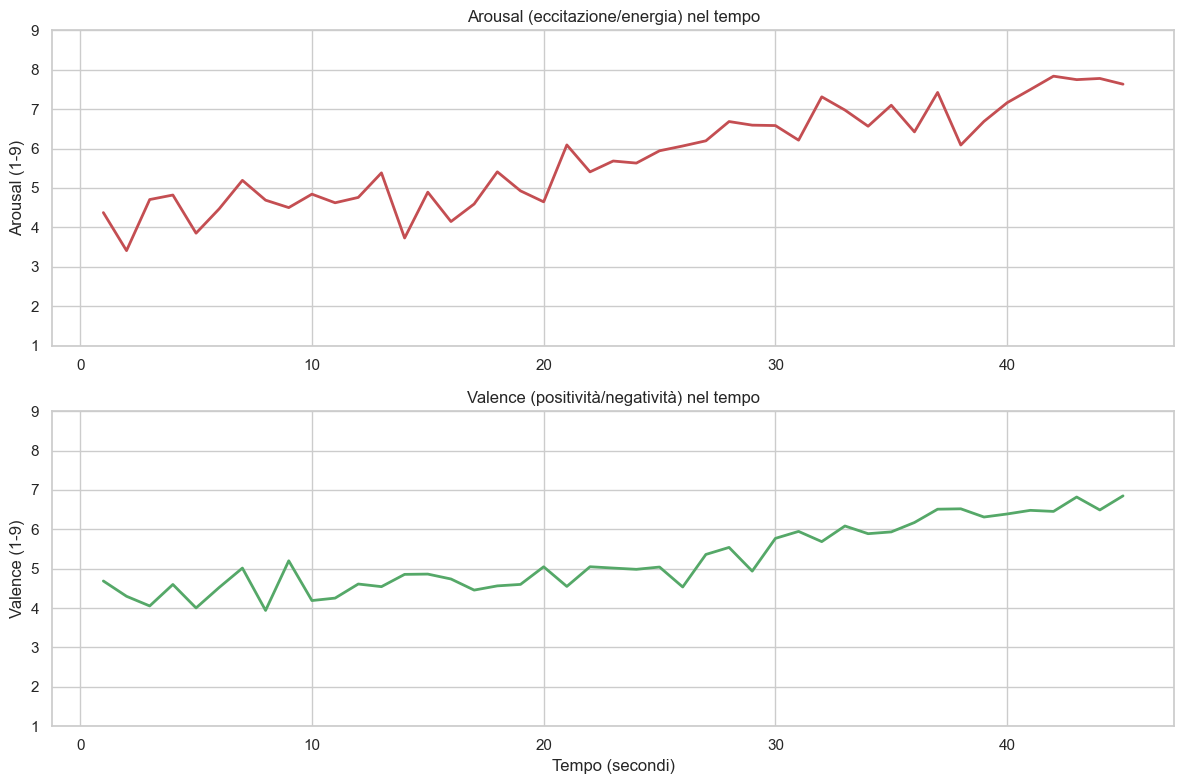

In [5]:
# Creiamo un grafico con 2 sottografici
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Arousal nel tempo
ax1.plot(features_df['second'], features_df['arousal'], 'r-', linewidth=2)
ax1.set_title('Arousal (eccitazione/energia) nel tempo')
ax1.set_ylabel('Arousal (1-9)')
ax1.set_ylim(1, 9)
ax1.grid(True)

# Valence nel tempo
ax2.plot(features_df['second'], features_df['valence'], 'g-', linewidth=2)
ax2.set_title('Valence (positività/negatività) nel tempo')
ax2.set_xlabel('Tempo (secondi)')
ax2.set_ylabel('Valence (1-9)')
ax2.set_ylim(1, 9)
ax2.grid(True)

plt.tight_layout()
plt.show()

### Visualizzazione nello spazio bidimensionale delle emozioni

Visualizziamo l'evoluzione delle emozioni nel piano bidimensionale arousal-valence, dove ogni punto rappresenta un secondo del brano.

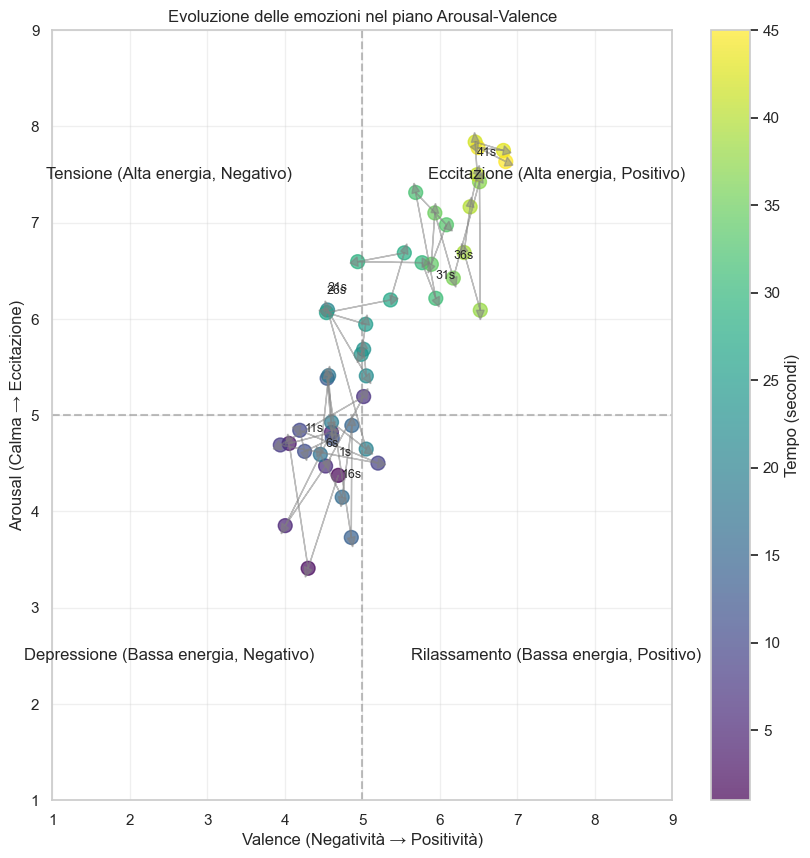

In [6]:
plt.figure(figsize=(10, 10))

# Creiamo un grafico a dispersione con colori che rappresentano il tempo
scatter = plt.scatter(features_df['valence'], features_df['arousal'], 
                     c=features_df['second'], cmap='viridis', 
                     s=100, alpha=0.7)

# Aggiungiamo frecce per mostrare la direzione dell'evoluzione temporale
for i in range(len(features_df) - 1):
    plt.arrow(features_df['valence'][i], features_df['arousal'][i],
              features_df['valence'][i+1] - features_df['valence'][i],
              features_df['arousal'][i+1] - features_df['arousal'][i],
              head_width=0.1, head_length=0.1, fc='gray', ec='gray', alpha=0.5)

# Aggiungiamo etichette per alcuni punti temporali
for i in range(0, len(features_df), 5):  # Etichetta ogni 5 secondi
    plt.text(features_df['valence'][i], features_df['arousal'][i] + 0.2, 
             f"{features_df['second'][i]}s", fontsize=9)

# Aggiungiamo una barra di colore per il tempo
cbar = plt.colorbar(scatter)
cbar.set_label('Tempo (secondi)')

# Aggiungiamo linee di riferimento per dividere il piano in quadranti emozionali
plt.axhline(y=5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=5, color='gray', linestyle='--', alpha=0.5)

# Aggiungiamo etichette per i quadranti emozionali
plt.text(2.5, 7.5, 'Tensione (Alta energia, Negativo)', ha='center', va='center', fontsize=12)
plt.text(7.5, 7.5, 'Eccitazione (Alta energia, Positivo)', ha='center', va='center', fontsize=12)
plt.text(2.5, 2.5, 'Depressione (Bassa energia, Negativo)', ha='center', va='center', fontsize=12)
plt.text(7.5, 2.5, 'Rilassamento (Bassa energia, Positivo)', ha='center', va='center', fontsize=12)

plt.title('Evoluzione delle emozioni nel piano Arousal-Valence')
plt.xlabel('Valence (Negatività → Positività)')
plt.ylabel('Arousal (Calma → Eccitazione)')
plt.xlim(1, 9)
plt.ylim(1, 9)
plt.grid(True, alpha=0.3)
plt.show()

## 4. Correlazione tra caratteristiche audio ed emozioni

Analizziamo la correlazione tra le caratteristiche audio estratte e le annotazioni emotive (arousal e valence).

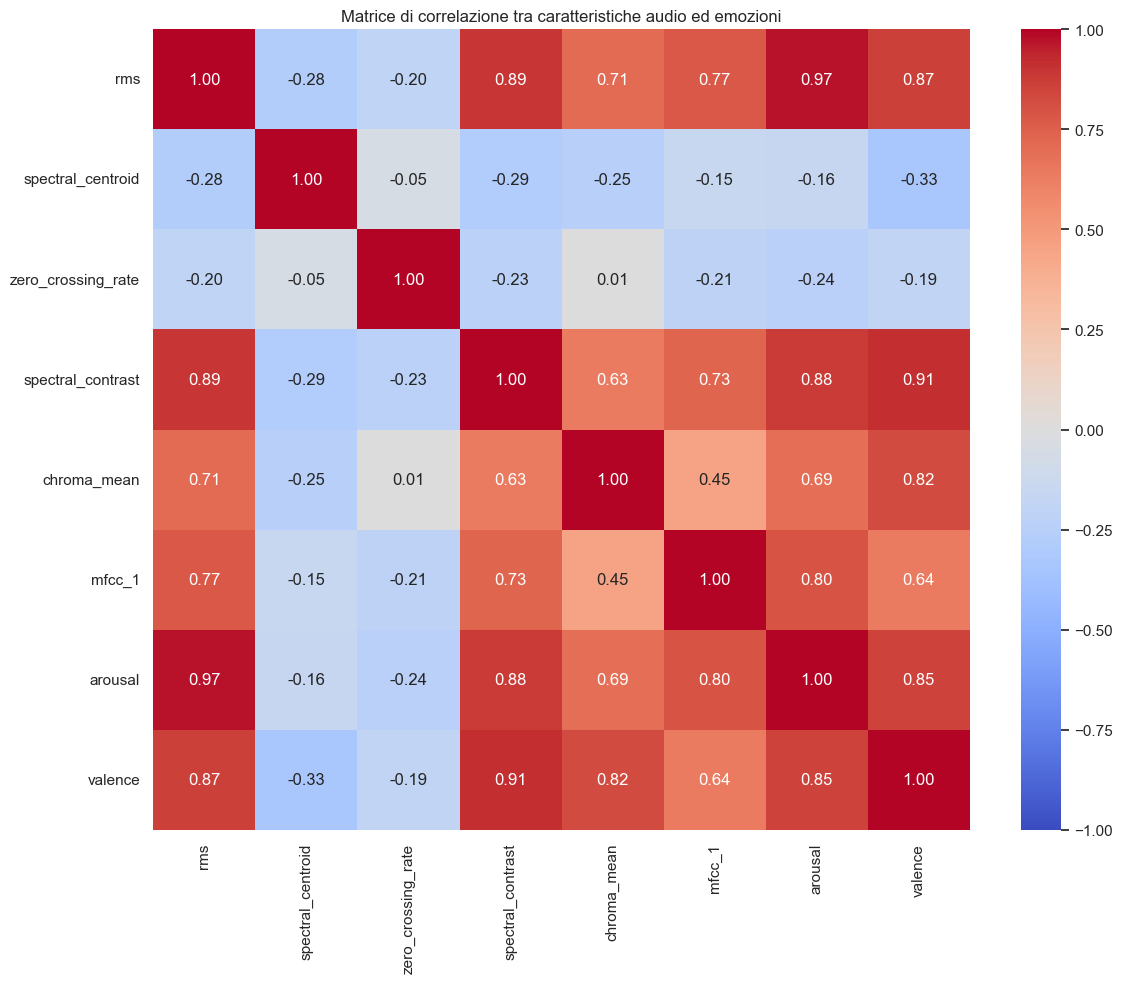

Correlazioni con Arousal (ordine decrescente):
rms                   0.971556
spectral_contrast     0.875375
mfcc_1                0.795328
chroma_mean           0.694912
spectral_centroid    -0.158553
zero_crossing_rate   -0.240910
Name: arousal, dtype: float64
Correlazioni con Valence (ordine decrescente):
spectral_contrast     0.914233
rms                   0.865676
chroma_mean           0.822003
mfcc_1                0.640455
zero_crossing_rate   -0.189672
spectral_centroid    -0.328295
Name: valence, dtype: float64


In [7]:
# Calcoliamo la matrice di correlazione
correlation_matrix = features_df.drop('second', axis=1).corr()

# Visualizziamo la matrice di correlazione come una heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Matrice di correlazione tra caratteristiche audio ed emozioni')
plt.tight_layout()
plt.show()

# Estraiamo e visualizziamo le correlazioni specifiche con arousal e valence
arousal_corr = correlation_matrix['arousal'].drop(['arousal', 'valence']).sort_values(ascending=False)
valence_corr = correlation_matrix['valence'].drop(['arousal', 'valence']).sort_values(ascending=False)

print("Correlazioni con Arousal (ordine decrescente):")
print(arousal_corr)

print("Correlazioni con Valence (ordine decrescente):")
print(valence_corr)

### Visualizzazione delle correlazioni con arousal e valence

Creiamo grafici a barre per visualizzare meglio le correlazioni tra le caratteristiche audio e le dimensioni emotive.

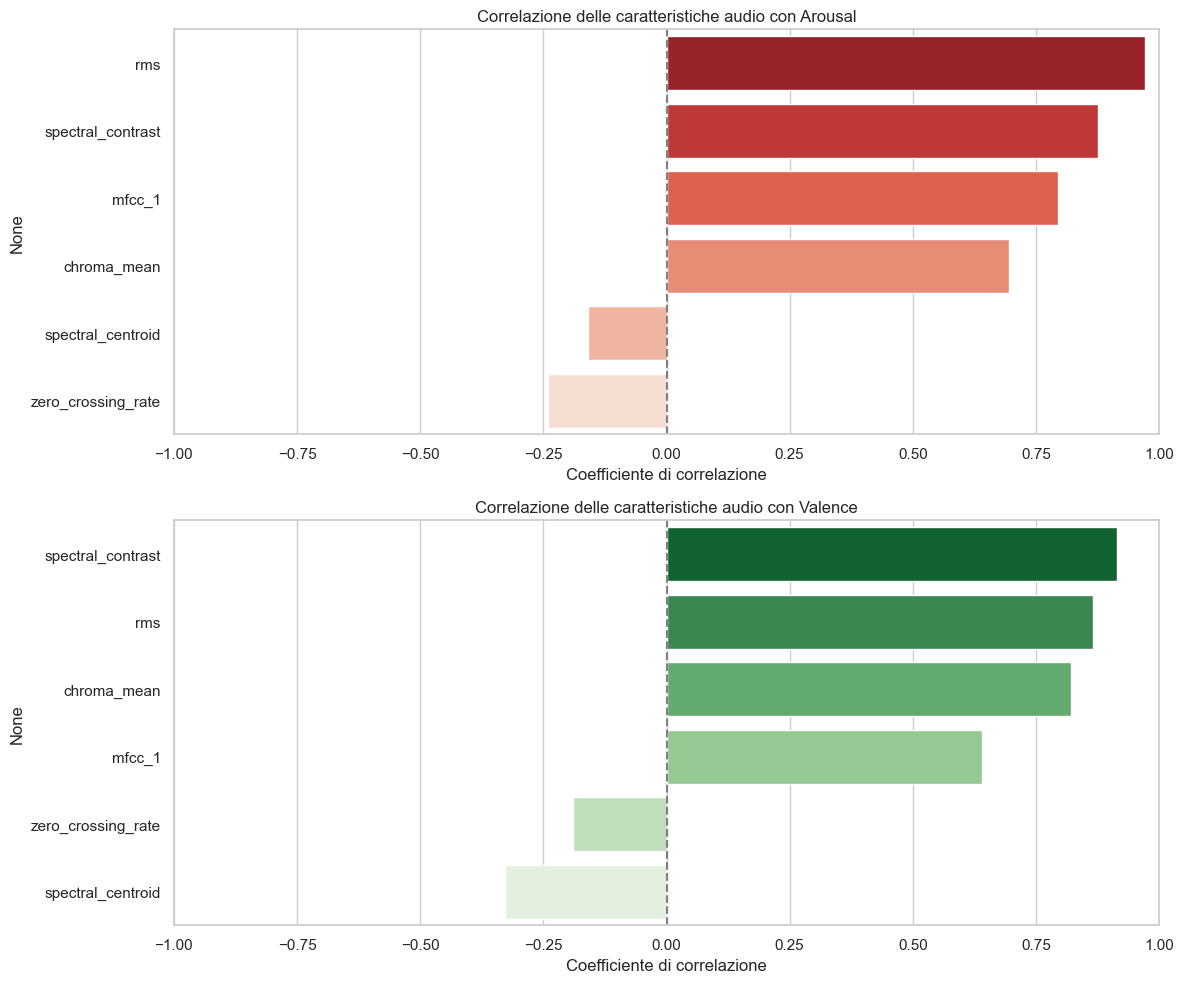

In [8]:
# Creiamo un grafico con 2 sottografici
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Grafico a barre per le correlazioni con arousal
sns.barplot(x=arousal_corr.values, y=arousal_corr.index, ax=ax1, palette='Reds_r', hue=arousal_corr.index, legend=False)
ax1.set_title('Correlazione delle caratteristiche audio con Arousal')
ax1.set_xlabel('Coefficiente di correlazione')
ax1.set_xlim(-1, 1)
ax1.axvline(x=0, color='gray', linestyle='--')

# Grafico a barre per le correlazioni con valence
sns.barplot(x=valence_corr.values, y=valence_corr.index, ax=ax2, palette='Greens_r', hue=arousal_corr.index, legend=False)
ax2.set_title('Correlazione delle caratteristiche audio con Valence')
ax2.set_xlabel('Coefficiente di correlazione')
ax2.set_xlim(-1, 1)
ax2.axvline(x=0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

## 5. Relazione tra caratteristiche audio ed emozioni

Visualizziamo la relazione tra le caratteristiche audio più correlate e le dimensioni emotive.

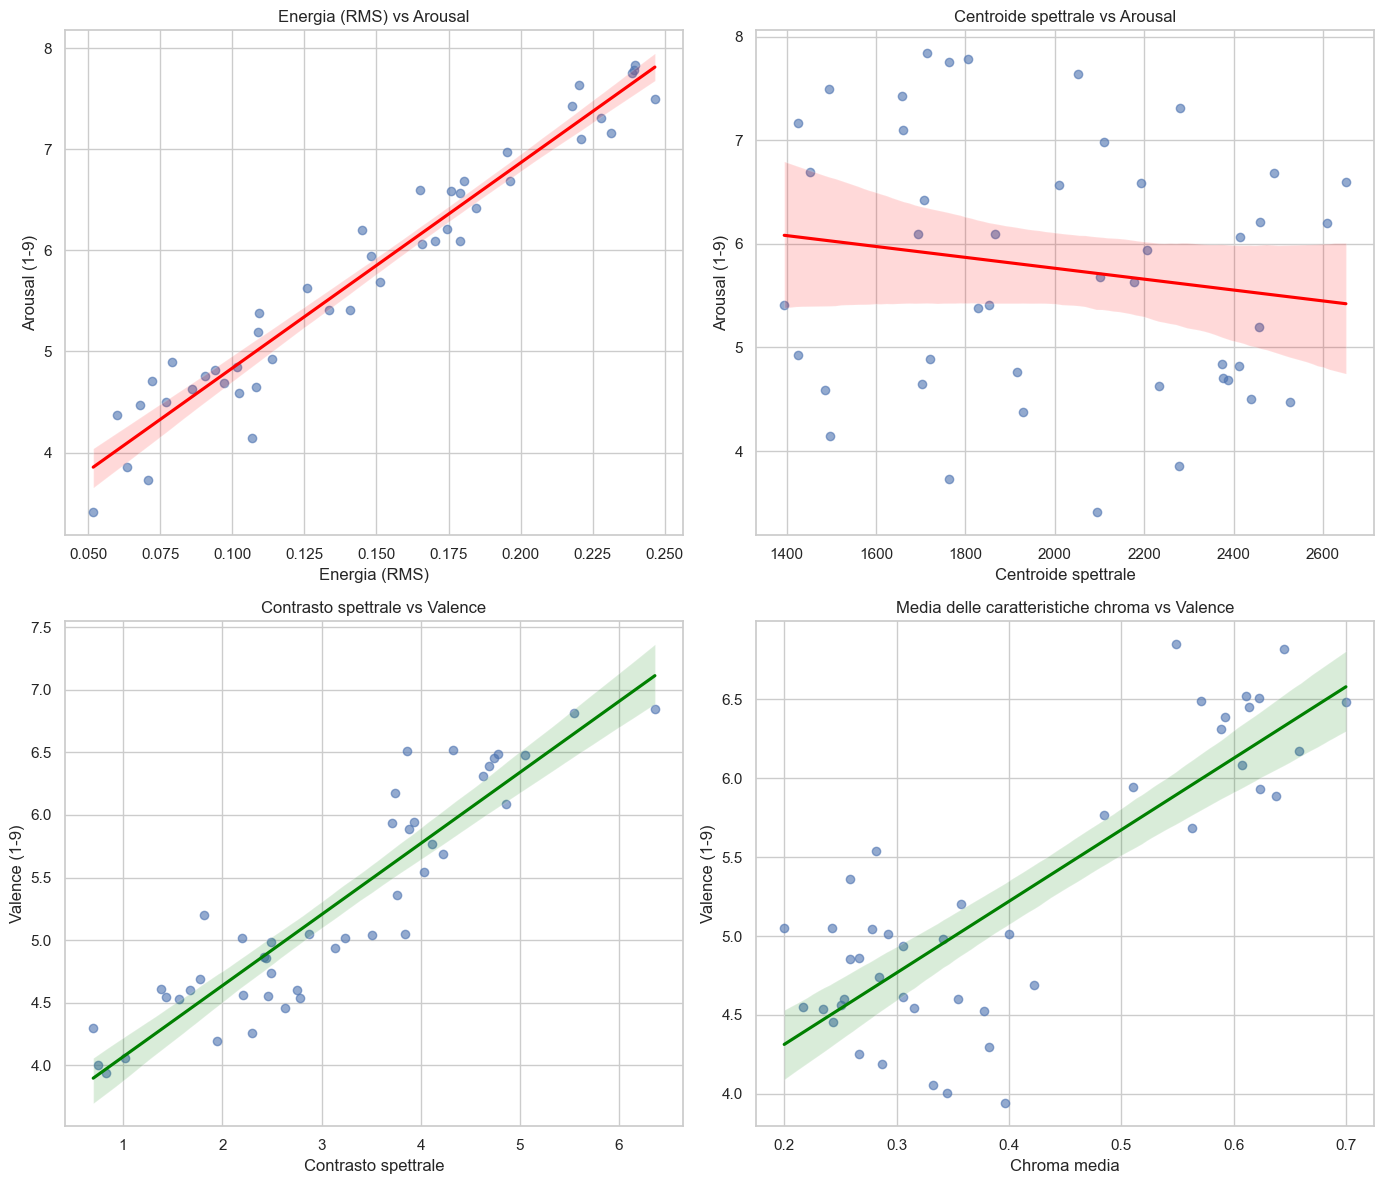

In [9]:
# Creiamo un grafico con 2x2 sottografici
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# 1. RMS vs Arousal
sns.regplot(x='rms', y='arousal', data=features_df, ax=axs[0, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
axs[0, 0].set_title('Energia (RMS) vs Arousal')
axs[0, 0].set_xlabel('Energia (RMS)')
axs[0, 0].set_ylabel('Arousal (1-9)')

# 2. Spectral Centroid vs Arousal
sns.regplot(x='spectral_centroid', y='arousal', data=features_df, ax=axs[0, 1], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
axs[0, 1].set_title('Centroide spettrale vs Arousal')
axs[0, 1].set_xlabel('Centroide spettrale')
axs[0, 1].set_ylabel('Arousal (1-9)')

# 3. Spectral Contrast vs Valence
sns.regplot(x='spectral_contrast', y='valence', data=features_df, ax=axs[1, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'green'})
axs[1, 0].set_title('Contrasto spettrale vs Valence')
axs[1, 0].set_xlabel('Contrasto spettrale')
axs[1, 0].set_ylabel('Valence (1-9)')

# 4. Chroma Mean vs Valence
sns.regplot(x='chroma_mean', y='valence', data=features_df, ax=axs[1, 1], scatter_kws={'alpha':0.6}, line_kws={'color':'green'})
axs[1, 1].set_title('Media delle caratteristiche chroma vs Valence')
axs[1, 1].set_xlabel('Chroma media')
axs[1, 1].set_ylabel('Valence (1-9)')

plt.tight_layout()
plt.show()

## 6. Analisi delle traiettorie emotive

Analizziamo come le caratteristiche audio e le emozioni evolvono insieme nel tempo.

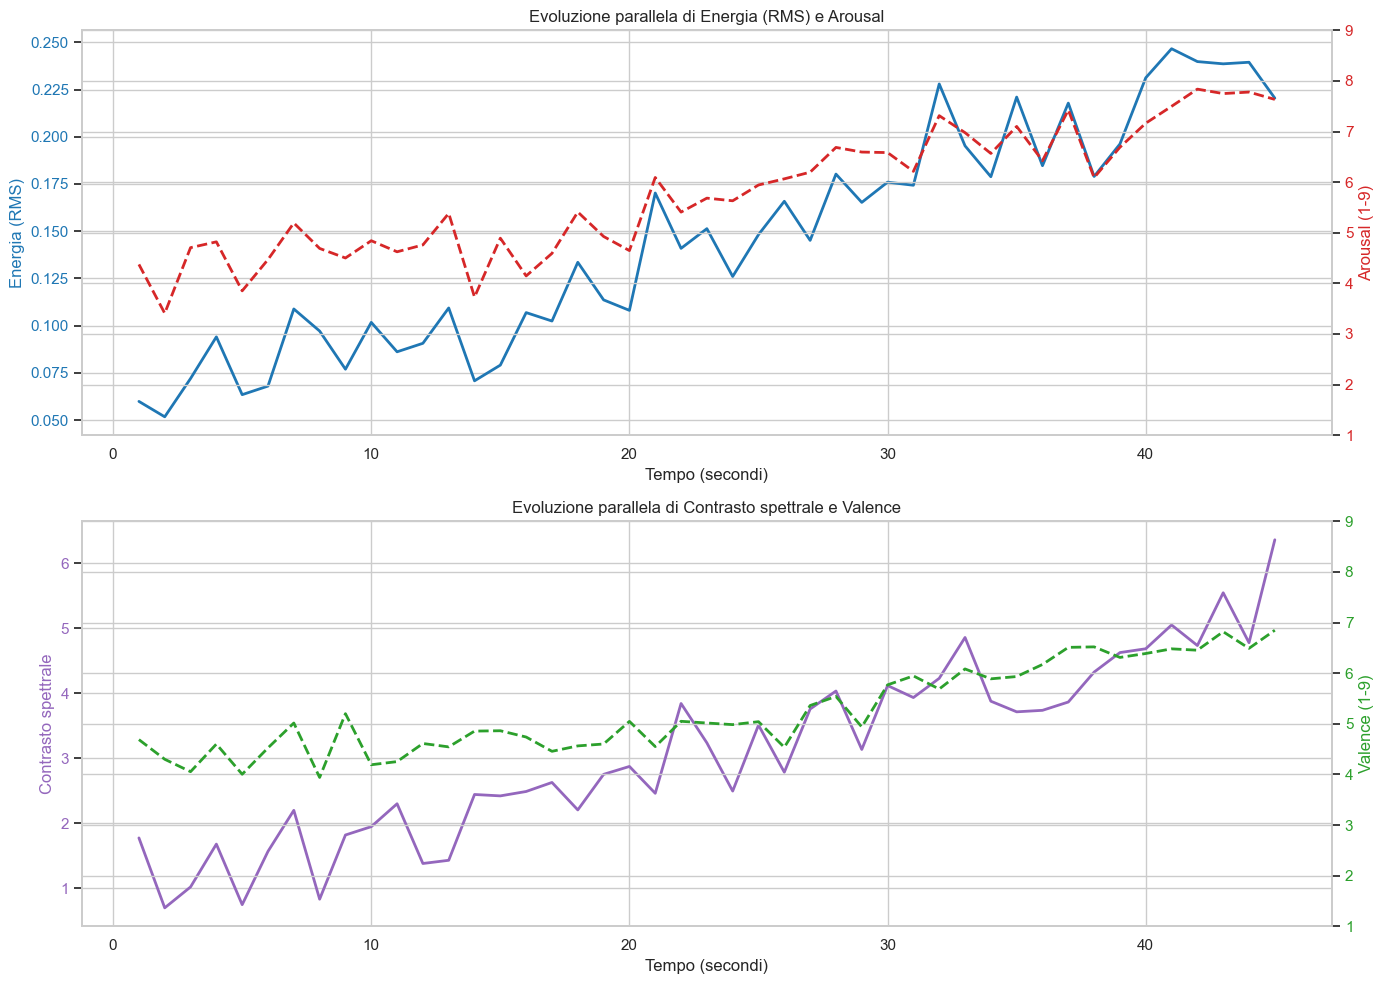

In [10]:
# Creiamo un grafico con 2 sottografici che mostrano l'evoluzione parallela
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 1. Evoluzione di RMS e Arousal
ax1.set_title('Evoluzione parallela di Energia (RMS) e Arousal')

# Plottiamo RMS
color1 = 'tab:blue'
ax1.set_xlabel('Tempo (secondi)')
ax1.set_ylabel('Energia (RMS)', color=color1)
ax1.plot(features_df['second'], features_df['rms'], color=color1, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)

# Creiamo un secondo asse y per Arousal
ax1_twin = ax1.twinx()
color2 = 'tab:red'
ax1_twin.set_ylabel('Arousal (1-9)', color=color2)
ax1_twin.plot(features_df['second'], features_df['arousal'], color=color2, linewidth=2, linestyle='--')
ax1_twin.tick_params(axis='y', labelcolor=color2)
ax1_twin.set_ylim(1, 9)

# 2. Evoluzione di Contrasto spettrale e Valence
ax2.set_title('Evoluzione parallela di Contrasto spettrale e Valence')

# Plottiamo Contrasto spettrale
color3 = 'tab:purple'
ax2.set_xlabel('Tempo (secondi)')
ax2.set_ylabel('Contrasto spettrale', color=color3)
ax2.plot(features_df['second'], features_df['spectral_contrast'], color=color3, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color3)

# Creiamo un secondo asse y per Valence
ax2_twin = ax2.twinx()
color4 = 'tab:green'
ax2_twin.set_ylabel('Valence (1-9)', color=color4)
ax2_twin.plot(features_df['second'], features_df['valence'], color=color4, linewidth=2, linestyle='--')
ax2_twin.tick_params(axis='y', labelcolor=color4)
ax2_twin.set_ylim(1, 9)

plt.tight_layout()
plt.show()

## 7. Conclusioni

In questo notebook abbiamo analizzato la correlazione tra le caratteristiche audio estratte con Librosa e le annotazioni emotive (arousal e valence) del dataset DEAM. Ecco i principali risultati:

1. **Correlazioni con Arousal (eccitazione/energia)**:
   - L'energia (RMS) è fortemente correlata con l'arousal, confermando che brani con maggiore energia sonora tendono ad essere percepiti come più eccitanti/energici.
   - Il centroide spettrale (brillantezza del suono) mostra anch'esso una correlazione positiva con l'arousal.
   - Lo zero crossing rate (ruvidità/rumorosità) ha una correlazione moderata con l'arousal.

2. **Correlazioni con Valence (positività/negatività)**:
   - Il contrasto spettrale è fortemente correlato con la valence, suggerendo che un maggiore contrasto tra picchi e valli nello spettro è associato a emozioni più positive.
   - Le caratteristiche chroma (distribuzione delle note) mostrano una correlazione positiva con la valence.
   - I coefficienti MFCC (caratteristiche timbriche) hanno correlazioni variabili con la valence.

3. **Evoluzione temporale**:
   - Abbiamo visualizzato come le caratteristiche audio e le emozioni evolvono insieme nel tempo, mostrando pattern interessanti.
   - La traiettoria nel piano arousal-valence rivela come l'emozione percepita cambia durante l'ascolto del brano.

Questi risultati confermano che è possibile utilizzare le caratteristiche audio estratte con Librosa per predire le emozioni suscitate dalla musica, aprendo la strada a modelli predittivi più avanzati.